# CNN and Quantization

## Exercise 1: CNN on CIFAR10

The goal is to apply a Convolutional Neural Net (CNN) model on the CIFAR10 image dataset and test the accuracy of the model on the basis of image classification. Compare the Accuracy VS the neural network implemented during TD1.

Have a look at the following documentation to be familiar with PyTorch.

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

You can test if GPU is available on your machine and thus train on it to speed up the process

In [2]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available!  Training on GPU ...")

CUDA is not available.  Training on CPU ...


Next we load the CIFAR10 dataset

In [3]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# choose the training and test datasets
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)

# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified
Files already downloaded and verified


CNN definition (this one is an example)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.quantization

# define the CNN architecture


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Loss function and training using SGD (Stochastic Gradient Descent) optimizer

In [ ]:
import torch.optim as optim
def train_NN(model, saving_name):
  criterion = nn.CrossEntropyLoss()  # specify loss function
  optimizer = optim.SGD(model.parameters(), lr=0.01)  # specify optimizer

  n_epochs = 30  # number of epochs to train the model
  train_loss_list = []  # list to store loss to visualize
  valid_loss_list = []
  valid_loss_min = np.inf  # track change in validation loss

  for epoch in range(n_epochs):
      # Keep track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0

      # Train the model
      model.train()
      for data, target in train_loader:
          # Move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # Clear the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # Calculate the batch loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item() * data.size(0)

      # Validate the model
      model.eval()
      for data, target in valid_loader:
          # Move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # Forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # Calculate the batch loss
          loss = criterion(output, target)
          # Update average validation loss
          valid_loss += loss.item() * data.size(0)

      # Calculate average losses
      train_loss = train_loss / len(train_loader)
      valid_loss = valid_loss / len(valid_loader)
      train_loss_list.append(train_loss)
      valid_loss_list.append(valid_loss)

      # Print training/validation statistics
      print(
          "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
              epoch, train_loss, valid_loss
          )
      )

      # Save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print(
              "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                  valid_loss_min, valid_loss
              )
          )
          torch.save(model.state_dict(), saving_name)
          valid_loss_min = valid_loss
  return train_loss_list, valid_loss_list

train_loss_list, valid_loss_list = train_NN(model, "model_cifar.pt")

Epoch: 0 	Training Loss: 43.177537 	Validation Loss: 38.673239
Validation loss decreased (inf --> 38.673239).  Saving model ...
Epoch: 1 	Training Loss: 34.551784 	Validation Loss: 31.565983
Validation loss decreased (38.673239 --> 31.565983).  Saving model ...
Epoch: 2 	Training Loss: 30.532303 	Validation Loss: 29.675056
Validation loss decreased (31.565983 --> 29.675056).  Saving model ...
Epoch: 3 	Training Loss: 28.342204 	Validation Loss: 27.452221
Validation loss decreased (29.675056 --> 27.452221).  Saving model ...
Epoch: 4 	Training Loss: 26.707589 	Validation Loss: 26.531921
Validation loss decreased (27.452221 --> 26.531921).  Saving model ...
Epoch: 5 	Training Loss: 25.328902 	Validation Loss: 25.729838
Validation loss decreased (26.531921 --> 25.729838).  Saving model ...
Epoch: 6 	Training Loss: 24.185963 	Validation Loss: 24.330657
Validation loss decreased (25.729838 --> 24.330657).  Saving model ...
Epoch: 7 	Training Loss: 23.149021 	Validation Loss: 24.283383
Valid

**Does overfit occur? If so, do an early stopping.**

Yes, overfit occurs. We can see this with the validation loss increasing at the end. The early stopping is alreayd kind of implemented, because we save the model only if its validation loss is the lowest at this moment.

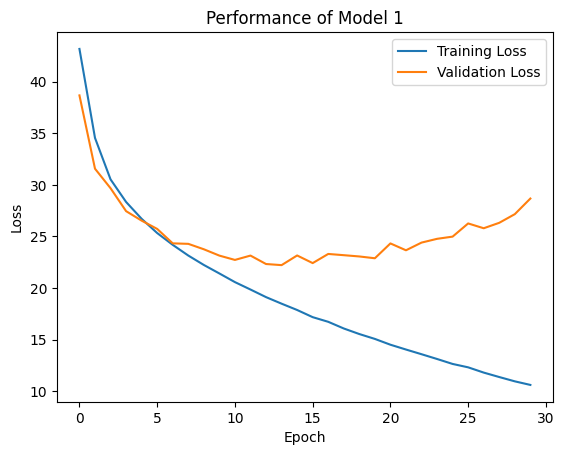

In [ ]:
import matplotlib.pyplot as plt

n_epochs = 30

plt.plot(range(n_epochs), train_loss_list, label="Training Loss")
plt.plot(range(n_epochs), valid_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.legend()
plt.show()

Now loading the model with the lowest validation loss value


In [ ]:
def test_NN(model, model_name):
  model.load_state_dict(torch.load(model_name))

  # track test loss
  test_loss = 0.0
  class_correct = list(0.0 for i in range(10))
  class_total = list(0.0 for i in range(10))
  criterion = nn.CrossEntropyLoss()  # specify loss function

  model.eval()
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = (
          np.squeeze(correct_tensor.numpy())
          if not train_on_gpu
          else np.squeeze(correct_tensor.cpu().numpy())
      )
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # average test loss
  test_loss = test_loss / len(test_loader)
  print("Test Loss: {:.6f}\n".format(test_loss))

  for i in range(10):
      if class_total[i] > 0:
          print(
              "Test Accuracy of %5s: %2d%% (%2d/%2d)"
              % (
                  classes[i],
                  100 * class_correct[i] / class_total[i],
                  np.sum(class_correct[i]),
                  np.sum(class_total[i]),
              )
          )
      else:
          print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

  print(
      "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
      % (
          100.0 * np.sum(class_correct) / np.sum(class_total),
          np.sum(class_correct),
          np.sum(class_total),
      )
  )



In [ ]:
model = Net()
test_NN(model, "./model_cifar.pt")

<ipython-input-10-9ea8cc8e9c77>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


Test Loss: 21.759473

Test Accuracy of airplane: 62% (624/1000)
Test Accuracy of automobile: 72% (725/1000)
Test Accuracy of  bird: 37% (372/1000)
Test Accuracy of   cat: 42% (429/1000)
Test Accuracy of  deer: 53% (530/1000)
Test Accuracy of   dog: 48% (485/1000)
Test Accuracy of  frog: 74% (747/1000)
Test Accuracy of horse: 74% (749/1000)
Test Accuracy of  ship: 80% (806/1000)
Test Accuracy of truck: 73% (738/1000)

Test Accuracy (Overall): 62% (6205/10000)


Build a new network with the following structure.

- It has 3 convolutional layers of kernel size 3 and padding of 1.
- The first convolutional layer must output 16 channels, the second 32 and the third 64.
- At each convolutional layer output, we apply a ReLU activation then a MaxPool with kernel size of 2.
- Then, three fully connected layers, the first two being followed by a ReLU activation and a dropout whose value you will suggest.
- The first fully connected layer will have an output size of 512.
- The second fully connected layer will have an output size of 64.

Compare the results obtained with this new network to those obtained previously.

In [5]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# create a complete CNN
model2 = Net2()
print(model2)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model2.cuda()


Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
train_loss_list2, valid_loss_list2 = train_NN(model2, "model2_cifar.pt")

Epoch: 0 	Training Loss: 45.780724 	Validation Loss: 43.652655
Validation loss decreased (inf --> 43.652655).  Saving model ...
Epoch: 1 	Training Loss: 39.921434 	Validation Loss: 35.266872
Validation loss decreased (43.652655 --> 35.266872).  Saving model ...
Epoch: 2 	Training Loss: 34.773858 	Validation Loss: 31.786129
Validation loss decreased (35.266872 --> 31.786129).  Saving model ...
Epoch: 3 	Training Loss: 32.198352 	Validation Loss: 30.084654
Validation loss decreased (31.786129 --> 30.084654).  Saving model ...
Epoch: 4 	Training Loss: 30.302291 	Validation Loss: 27.624043
Validation loss decreased (30.084654 --> 27.624043).  Saving model ...
Epoch: 5 	Training Loss: 28.653563 	Validation Loss: 26.193765
Validation loss decreased (27.624043 --> 26.193765).  Saving model ...
Epoch: 6 	Training Loss: 27.244442 	Validation Loss: 25.954172
Validation loss decreased (26.193765 --> 25.954172).  Saving model ...
Epoch: 7 	Training Loss: 25.832194 	Validation Loss: 23.255186
Valid

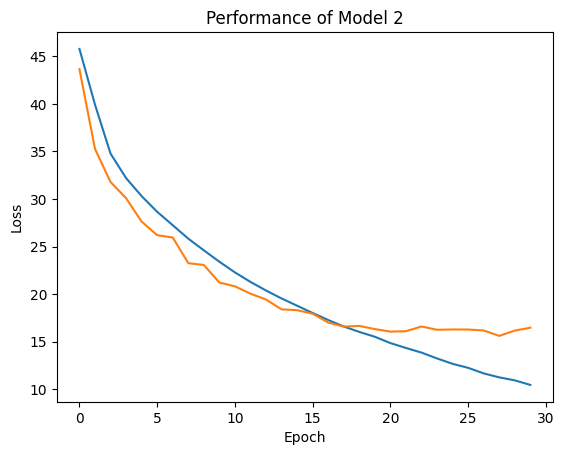

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(n_epochs), train_loss_list2)
plt.plot(range(n_epochs), valid_loss_list2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 2")
plt.show()

For this model the validation loss is stabilizing at the end. We don't have the overfitting we have on the precedent model.

This is because we have added droupout layers, which add regularization to the model to prevent overfitting and improve generalization.

In [ ]:
model2 = Net2()
model2.cuda()
test_NN(model2, "./model2_cifar.pt")

<ipython-input-10-9ea8cc8e9c77>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


Test Loss: 15.926801

Test Accuracy of airplane: 78% (782/1000)
Test Accuracy of automobile: 87% (873/1000)
Test Accuracy of  bird: 68% (687/1000)
Test Accuracy of   cat: 60% (601/1000)
Test Accuracy of  deer: 67% (679/1000)
Test Accuracy of   dog: 53% (539/1000)
Test Accuracy of  frog: 79% (794/1000)
Test Accuracy of horse: 74% (741/1000)
Test Accuracy of  ship: 84% (848/1000)
Test Accuracy of truck: 79% (798/1000)

Test Accuracy (Overall): 73% (7342/10000)


The accuracy is way better for the second model (from 62% to 74%). This is coherent because the second Neural Network is more complex. As said before, we added a dropout layer to prevent overfitting, but we also added more convolutional layers, with higher number of channels.

So, the model gives better results but is heavier (it has more parameters).

## Exercise 2: Quantization: try to compress the CNN to save space

Quantization doc is available from https://pytorch.org/docs/stable/quantization.html#torch.quantization.quantize_dynamic
        
The Exercise is to quantize post training the above CNN model. Compare the size reduction and the impact on the classification accuracy


The size of the model is simply the size of the file.

In [6]:
import os
import torch.quantization

def size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    os.remove("temp.p")
    return size

def quantize_model(model):
    original_size = size_of_model(model, "fp32")
    quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)
    quantized_size = size_of_model(quantized_model, "int8")
    print("Model size reduction: {}%".format(100 * (original_size - quantized_size) / original_size))
    return quantized_model

Post training quantization on the first model

In [ ]:
model = Net()
model.load_state_dict(torch.load("./model_cifar.pt"))

quantized_model = quantize_model(model)

Model size reduction: 69.54687636800675%


<ipython-input-9-af5856a663d5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model_cifar.pt"))


In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

quantized_model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.to('cpu'), target.to('cpu')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = quantized_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

Test Loss: 22.005554

Test Accuracy of airplane: 67% (671/1000)
Test Accuracy of automobile: 70% (701/1000)
Test Accuracy of  bird: 50% (505/1000)
Test Accuracy of   cat: 37% (379/1000)
Test Accuracy of  deer: 48% (483/1000)
Test Accuracy of   dog: 59% (597/1000)
Test Accuracy of  frog: 83% (830/1000)
Test Accuracy of horse: 63% (638/1000)
Test Accuracy of  ship: 76% (762/1000)
Test Accuracy of truck: 65% (656/1000)

Test Accuracy (Overall): 62% (6222/10000)


The test results of the quantized model are very similar to those of the original model. The accuracies (for each class or the overall one) are very close, 62% overall for both models.

However, the quantized model's size is 70% smaller.

Post training quantization on the second model

In [ ]:
model2 = Net2()
model2.load_state_dict(torch.load("./model2_cifar.pt"))

quantized_model2 = quantize_model(model2)

model:  int8  	 Size (KB): 659.806


<ipython-input-15-716f4a01144b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("./model2_cifar.pt"))


659806

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

quantized_model2.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.to('cpu'), target.to('cpu')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = quantized_model2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

Test Loss: 15.812374

Test Accuracy of airplane: 81% (814/1000)
Test Accuracy of automobile: 86% (863/1000)
Test Accuracy of  bird: 69% (696/1000)
Test Accuracy of   cat: 55% (558/1000)
Test Accuracy of  deer: 69% (694/1000)
Test Accuracy of   dog: 54% (541/1000)
Test Accuracy of  frog: 83% (835/1000)
Test Accuracy of horse: 77% (772/1000)
Test Accuracy of  ship: 84% (849/1000)
Test Accuracy of truck: 81% (813/1000)

Test Accuracy (Overall): 74% (7435/10000)


**For each class, compare the classification test accuracy of the initial model and the quantized model. Also give the overall test accuracy for both models.**

Once again like for the first model, the overall accuracy of the quantized model is nearly the same as the one of the original model. This time, we have a bit more difference for the classes' accuracies, but not much neither, and it compensates between the different classes so the overall accuracy remains almost unchanged.

The quantized model is again approximately 70% lighter.

It appears that quantization for those models is very effective because it has nearly no effect on the quality of the model, but reduces significantly models' sizes.

**Try training aware quantization to mitigate the impact on the accuracy (doc available here https://pytorch.org/docs/stable/quantization.html#torch.quantization.quantize_dynamic)**

In [ ]:
import torch
import torch.optim as optim
import numpy as np

def train_NN_QAT(model, saving_name):
    # Prepare the model for quantization-aware training
    model.train()  # Set the model to training mode
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')  # Set QAT configuration
    torch.quantization.prepare_qat(model, inplace=True)  # Prepare the model for QAT

    criterion = nn.CrossEntropyLoss()  # specify loss function
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # specify optimizer

    n_epochs = 30  # number of epochs to train the model
    train_loss_list = []  # list to store loss to visualize
    valid_loss_list = []
    valid_loss_min = np.inf  # track change in validation loss

    for epoch in range(n_epochs):
        # Keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # Train the model
        model.train()
        for data, target in train_loader:
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Update training loss
            train_loss += loss.item() * data.size(0)

        # Validate the model
        model.eval()
        for data, target in valid_loader:
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update average validation loss
            valid_loss += loss.item() * data.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        # Save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    valid_loss_min, valid_loss
                )
            )
            torch.save(model.state_dict(), "model_qat_temp.pt")
            valid_loss_min = valid_loss

    # Convert the model to quantized after training
    model.load_state_dict(torch.load("model_qat_temp.pt"))
    model.cpu()  # Ensure it's on the CPU for quantization
    quantized_model = torch.quantization.convert(model.eval(), inplace=False)
    torch.save(quantized_model.state_dict(), saving_name)

    return quantized_model, train_loss_list, valid_loss_list


In [8]:
model = Net()
qat_model, train_loss_list_qat, valid_loss_list_qat = train_NN_QAT(model, "model_cifar_qat.pt")

c:\Python312\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Epoch: 0 	Training Loss: 44.694443 	Validation Loss: 40.313680
Validation loss decreased (inf --> 40.313680).  Saving model ...
Epoch: 1 	Training Loss: 36.346298 	Validation Loss: 32.868665
Validation loss decreased (40.313680 --> 32.868665).  Saving model ...
Epoch: 2 	Training Loss: 31.280098 	Validation Loss: 29.359002
Validation loss decreased (32.868665 --> 29.359002).  Saving model ...


C:\Users\steva\AppData\Local\Temp\ipykernel_10476\3351992419.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_qat_temp.pt"))


In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
criterion = nn.CrossEntropyLoss()
qat_model.eval()
# iterate over test data
for data, target in test_loader:
    
    data, target = data.to('cpu'), target.to('cpu')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = qat_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\quantized\cpu\qconv.cpp:1972 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:96 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:87 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:100 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:91 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:321 [backend fallback]
AutocastXPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:463 [backend fallback]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:157 [backend fallback]


I can't test the qat model because my cpu doesn't support the convolutional function needed to do so. So, I can't compare the results of the qat model to the original one, but the training phase of qat worked at least.

And the qat model size is smaller than the normally trained model at least.

## Exercise 3: working with pre-trained models.

PyTorch offers several pre-trained models https://pytorch.org/vision/0.8/models.html        
We will use ResNet50 trained on ImageNet dataset (https://www.image-net.org/index.php). Use the following code with the files `imagenet-simple-labels.json` that contains the imagenet labels and the image dog.png that we will use as test.


Predicted class is: Golden Retriever


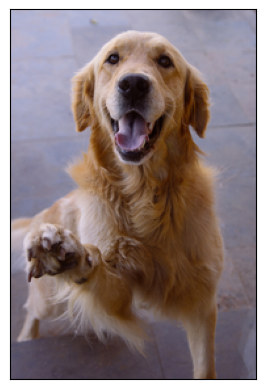

In [ ]:
import json
from PIL import Image

# Choose an image to pass through the model
dog_image = "dog.png"

# Configure matplotlib for pretty inline plots
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
# Prepare the labels
with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)

# Download the model if it's not there already. It will take a bit on the first run, after that it's fast
model_resnet = models.resnet50(pretrained=True)

def test_image_classification_resnet(test_image, model):
  # First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
  data_transform = transforms.Compose(
      [
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  )
  # Load the image

  image = Image.open(test_image)
  plt.imshow(image), plt.xticks([]), plt.yticks([])

  # Now apply the transformation, expand the batch dimension, and send the image to the GPU
  # image = data_transform(image).unsqueeze(0).cuda()
  image = data_transform(image).unsqueeze(0)

  # Send the model to the GPU
  # model.cuda()

  # Set layers such as dropout and batchnorm in evaluation mode
  model.eval()

  # Get the 1000-dimensional model output
  out = model(image)

  return out

predictions = test_image_classification_resnet(dog_image, model_resnet)
# Find the predicted class
print("Predicted class is: {}".format(labels[predictions.argmax()]))

**Experiments:**

Study the code and the results obtained. Possibly add other images downloaded from the internet.

What is the size of the model? Quantize it and then check if the model is still able to correctly classify the other images.

Experiment with other pre-trained CNN models.


First, we can see that the model is able to precisely identitfy what's on the image, a golden retriever. This is because ResNet50 has been trained on a lot of data to learn 1000 classes, including animal species.

Let's break down the above code to understand how to use it with our image.

First, we need to load the weights of the pre trained model, here we do it thanks to the models library of pytorch. Then, in order to give to the model the image, we need to tranform it. The input image of the model needs to have the same characteristics than the images on which the model has been trained (ImageNet dataset). Those training images have a 224x224 size, so we resize the test image. Moreover, the training dataset has a precise mean and standard error value, that's why we normalize the image so it has the same mean and standard erros values.

Once this is done, we can give the tranformed image to the model. The model will ouput an array of probabilities. They correpond to the probabilies of having the corresponding class (from the list of labels) in the image according to the model.

In this way if we take the higher probability, this is the prediction of the class of the content in the test image. If we have several entities on the image, for example 3, we can look at the 3 higher probabiities that should match the different entities.

Let's do some more tests on other images.

Predicted class is: basketball


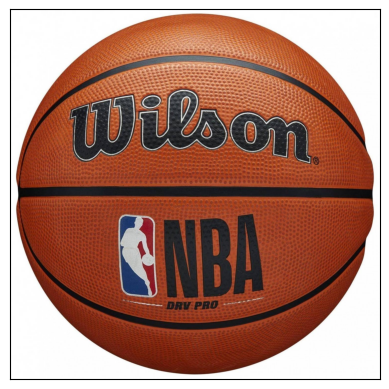

In [ ]:
basketball_image = "basketball.jpg"
predictions = test_image_classification_resnet(basketball_image, model_resnet)
# Find the predicted class
print("Predicted class is: {}".format(labels[predictions.argmax()]))

Predicted classes are: ['soccer ball', 'rugby ball', 'basketball', 'croquet ball', 'ping-pong ball', 'maraca']


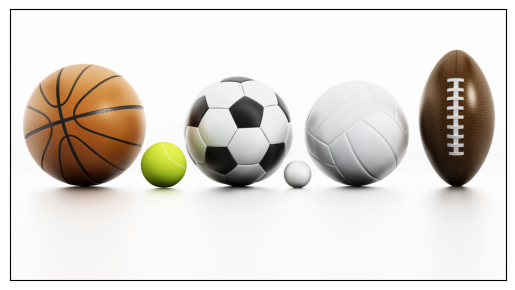

In [ ]:
multiple_balls_image = "multiple_balls.jpg"
predictions = test_image_classification_resnet(multiple_balls_image, model_resnet)
# Find the predicted class
top_probabilities, top_indices = torch.topk(predictions, 6)
top_classes = [labels[int(idx)] for idx in top_indices[0]]
print("Predicted classes are: {}".format(top_classes))

We can see that ResNet is able to identify several entities on an image, but it's not totally perfect for all of them.

Now let's quantize the model and test it again.

In [ ]:
import os
import torch.quantization

def size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    os.remove("temp.p")
    return size

def quantize_model(model):
    original_size = size_of_model(model, "fp32")
    quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)
    quantized_size = size_of_model(quantized_model, "int8")
    print("Model size reduction: {}%".format(100 * (original_size - quantized_size) / original_size))
    return quantized_model

We can directly load the quantized ResNet model from pytorch.models

In [ ]:
quantized_resnet_model = models.quantization.resnet50(
    weights=models.quantization.ResNet50_QuantizedWeights.IMAGENET1K_FBGEMM_V1,
    quantize=True
)

In [ ]:
size_resnet = size_of_model(model_resnet)
size_resnet_quantized = size_of_model(quantized_resnet_model)
size_reduction = (size_resnet - size_resnet_quantized) / size_resnet

In [ ]:
print(f'Size reduction of ResNet quantized is: {round(size_reduction*100, 2)}%')

Size reduction of ResNet quantized is: 74.49%


Predicted class is: Golden Retriever


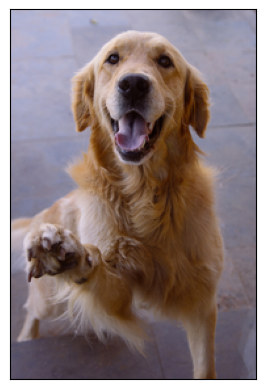

In [ ]:
predictions = test_image_classification_resnet(dog_image, quantized_resnet_model)
# Find the predicted class
print("Predicted class is: {}".format(labels[predictions.argmax()]))

Predicted class is: basketball


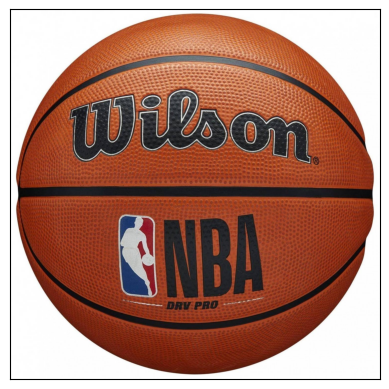

In [ ]:
predictions = test_image_classification_resnet(basketball_image, quantized_resnet_model)
# Find the predicted class
print("Predicted class is: {}".format(labels[predictions.argmax()]))

Predicted classes are: ['soccer ball', 'rugby ball', 'basketball', 'tennis ball', 'croquet ball', 'ping-pong ball']


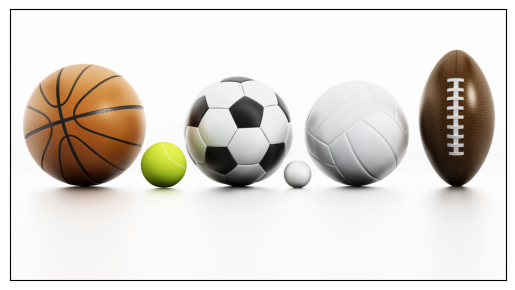

In [ ]:
predictions = test_image_classification_resnet(multiple_balls_image, quantized_resnet_model)
# Find the predicted classes
top_probabilities, top_indices = torch.topk(predictions, 6)
top_classes = [labels[int(idx)] for idx in top_indices[0]]
print("Predicted classes are: {}".format(top_classes))

Once again the results of the quantized ResNet model are the same as the original model, but its size is 75% smaller.

Now let's try with another pre-trained model: the VGG16.

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)

def test_image_classification_vgg(test_image, model):
  # First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
  data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet stats
  ])

  # Load the image
  image = Image.open(test_image)
  plt.imshow(image), plt.xticks([]), plt.yticks([])

  # Now apply the transformation, expand the batch dimension, and send the image to the GPU
  # image = data_transform(image).unsqueeze(0).cuda()
  image = data_transform(image).unsqueeze(0)

  # Send the model to the GPU
  # model.cuda()

  # Set layers such as dropout and batchnorm in evaluation mode
  model.eval()

  output = model(image)

  return output

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.8MB/s]


Class 1: Golden Retriever (Probability: 16.56%)


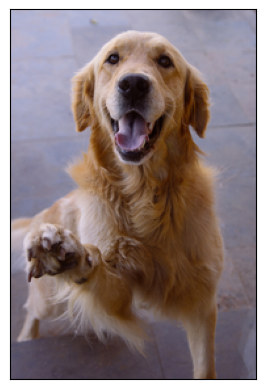

In [ ]:
predictions = test_image_classification_vgg(dog_image, model_vgg16)
top_prob, top_catid = torch.topk(predictions, 1)
for i in range(top_prob.size(1)):
    predicted_class = top_catid[0][i].item()
    predicted_label = labels[predicted_class]
    probability = top_prob[0][i].item()
    print(f"Class {i+1}: {predicted_label} (Probability: {probability:.2f}%)")

Class 1: basketball (Probability: 31.64%)


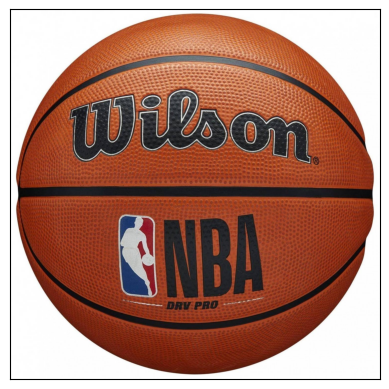

In [ ]:
predictions = test_image_classification_vgg(basketball_image, model_vgg16)
top_prob, top_catid = torch.topk(predictions, 1)
for i in range(top_prob.size(1)):
    predicted_class = top_catid[0][i].item()
    predicted_label = labels[predicted_class]
    probability = top_prob[0][i].item()
    print(f"Class {i+1}: {predicted_label} (Probability: {probability:.2f}%)")

Class 1: soccer ball (Probability: 22.01%)
Class 2: volleyball (Probability: 18.32%)
Class 3: ping-pong ball (Probability: 17.26%)
Class 4: croquet ball (Probability: 15.68%)
Class 5: billiard table (Probability: 15.67%)


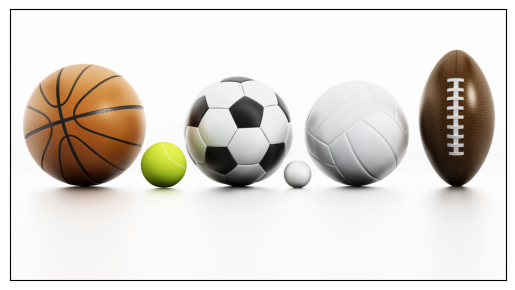

In [ ]:
predictions = test_image_classification_vgg(multiple_balls_image, model_vgg16)
top_prob, top_catid = torch.topk(predictions, 5)
for i in range(top_prob.size(1)):
    predicted_class = top_catid[0][i].item()
    predicted_label = labels[predicted_class]
    probability = top_prob[0][i].item()
    print(f"Class {i+1}: {predicted_label} (Probability: {probability:.2f}%)")

This model is also very good, and struggle on the same task: identifying several entities on an image. But it still manges to identify some of those on the multiple entities image

Now let's try to quantize it.

In [ ]:
quantized_vgg_model = quantize_model(model_vgg16)

Model size reduction: 67.0170704828562%


This time the quantization is really effective because it reduces the size by nearly 70%. But does the model has kept its quality?

Class 1: Golden Retriever (Probability: 16.63%)


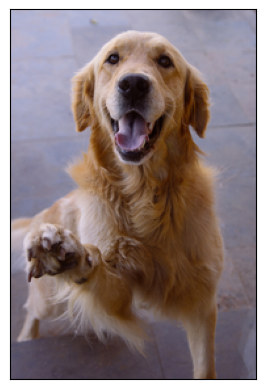

In [ ]:
predictions = test_image_classification_vgg(dog_image, quantized_vgg_model)
top_prob, top_catid = torch.topk(predictions, 1)
for i in range(top_prob.size(1)):
    predicted_class = top_catid[0][i].item()
    predicted_label = labels[predicted_class]
    probability = top_prob[0][i].item()
    print(f"Class {i+1}: {predicted_label} (Probability: {probability:.2f}%)")

Class 1: basketball (Probability: 31.67%)


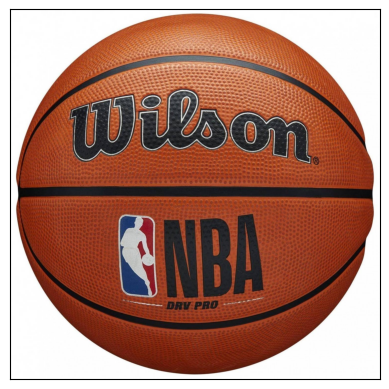

In [ ]:
predictions = test_image_classification_vgg(basketball_image, quantized_vgg_model)
top_prob, top_catid = torch.topk(predictions, 1)
for i in range(top_prob.size(1)):
    predicted_class = top_catid[0][i].item()
    predicted_label = labels[predicted_class]
    probability = top_prob[0][i].item()
    print(f"Class {i+1}: {predicted_label} (Probability: {probability:.2f}%)")

Class 1: soccer ball (Probability: 22.07%)
Class 2: volleyball (Probability: 18.35%)
Class 3: ping-pong ball (Probability: 17.28%)
Class 4: croquet ball (Probability: 15.75%)
Class 5: billiard table (Probability: 15.68%)


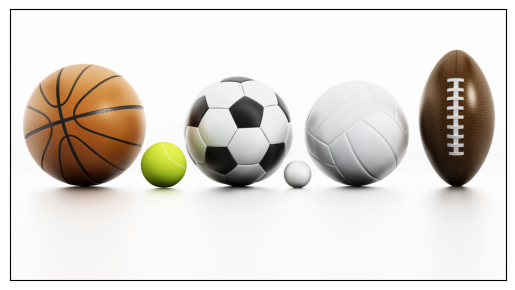

In [ ]:
predictions = test_image_classification_vgg(multiple_balls_image, quantized_vgg_model)
top_prob, top_catid = torch.topk(predictions, 5)
for i in range(top_prob.size(1)):
    predicted_class = top_catid[0][i].item()
    predicted_label = labels[predicted_class]
    probability = top_prob[0][i].item()
    print(f"Class {i+1}: {predicted_label} (Probability: {probability:.2f}%)")

The results are once again similar after quantization, even the probability of each class is very similar.

The quantization is then very effective for this model, as it reduces the size by 70%, without any significant loss of prediction quality.

## Exercise 4: Transfer Learning
    
    
For this work, we will use a pre-trained model (ResNet18) as a descriptor extractor and will refine the classification by training only the last fully connected layer of the network. Thus, the output layer of the pre-trained network will be replaced by a layer adapted to the new classes to be recognized which will be in our case ants and bees.
Download and unzip in your working directory the dataset available at the address :
    
https://download.pytorch.org/tutorial/hymenoptera_data.zip
    
Execute the following code in order to display some images of the dataset.

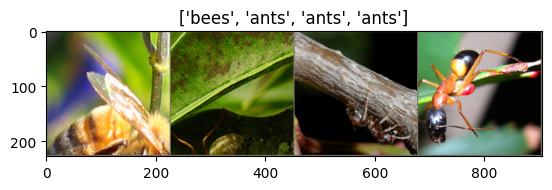

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(
                224
            ),  # ImageNet models were trained on 224x224 images
            transforms.RandomHorizontalFlip(),  # flip horizontally 50% of the time - increases train set variability
            transforms.ToTensor(),  # convert it to a PyTorch tensor
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # ImageNet models expect this norm
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "hymenoptera_data"
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=0
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



Now, execute the following code which uses a pre-trained model ResNet18 having replaced the output layer for the ants/bees classification and performs the model training by only changing the weights of this output layer.

In [ ]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import random_split, ConcatDataset

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(
                224
            ),  # ImageNet models were trained on 224x224 images
            transforms.RandomHorizontalFlip(),  # flip horizontally 50% of the time - increases train set variability
            transforms.ToTensor(),  # convert it to a PyTorch tensor
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # ImageNet models expect this norm
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


data_dir = "hymenoptera_data"
# Create train, validation and test datasets and loaders
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])

# Combine the datasets into a single dataset
all_data = ConcatDataset([train_data, val_data])

# Calculate the sizes for train, val, and test splits
total_size = len(all_data)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(all_data, [train_size, val_size, test_size])
image_datasets = {
    "train": train_dataset, "val": val_dataset, "test": test_dataset
}
# Create DataLoaders for each split
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val", "test"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = train_data.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
# training


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_time = []  # we'll keep track of the time needed for each epoch

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time, train_losses, val_losses

In [ ]:
# Download a pre-trained ResNet18 model and freeze its weights
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
num_epochs = 10
model, epoch_time, train_losses, val_losses = train_model(
    model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs
)

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------


c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.5584 Acc: 0.7004
val Loss: 0.1525 Acc: 0.9492

Epoch 2/10
----------
train Loss: 0.6536 Acc: 0.7040
val Loss: 0.1875 Acc: 0.9322

Epoch 3/10
----------
train Loss: 0.4815 Acc: 0.8195
val Loss: 0.1338 Acc: 0.9322

Epoch 4/10
----------
train Loss: 0.4688 Acc: 0.8231
val Loss: 0.1405 Acc: 0.9492

Epoch 5/10
----------
train Loss: 0.3642 Acc: 0.8556
val Loss: 0.1486 Acc: 0.9492

Epoch 6/10
----------
train Loss: 0.3887 Acc: 0.8375
val Loss: 0.3179 Acc: 0.8644

Epoch 7/10
----------
train Loss: 0.3665 Acc: 0.8556
val Loss: 0.1421 Acc: 0.9492

Epoch 8/10
----------
train Loss: 0.3085 Acc: 0.8520
val Loss: 0.2393 Acc: 0.8475

Epoch 9/10
----------
train Loss: 0.3041 Acc: 0.8773
val Loss: 0.1116 Acc: 0.9492

Epoch 10/10
----------
train Loss: 0.3053 Acc: 0.8628
val Loss: 0.1307 Acc: 0.9492

Training complete in 7m 43s
Best val Acc: 0.949153


**Experiments:
Study the code and the results obtained.**

The code is similar to what we have done before. We train the model on the training data, and we evaluate the new model at each training step on the validation data. If the validation loss is lower than the lowest at this moment, we save the parameters. At the end, we return the best model obtined during training.

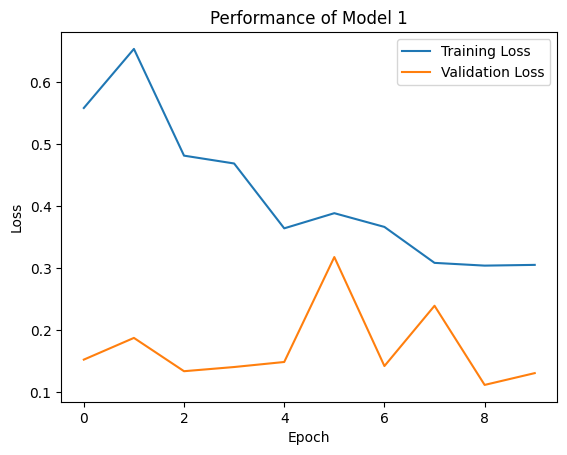

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.legend()
plt.show()

The trend of the validation loss is to decrease during training, and seems to stabilize. The validation loss doesn't really increase which means that there should not be overfitting.

**Modify the code and add an "eval_model" function to allow the evaluation of the model on a test set (different from the learning and validation sets used during the learning phase). Study the results obtained.**

In [ ]:
def test_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []

    # Disable gradient computation for testing
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    test_loss = running_loss / len(dataloader.dataset)
    test_accuracy = running_corrects.double() / len(dataloader.dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Test the model
test_model(model, dataloaders["test"], criterion)

Test Loss: 0.1726
Test Accuracy: 0.9180


We have an accuracy of 92% during testing.

**Now modify the code to replace the current classification layer with a set of two layers using a "relu" activation function for the middle layer, and the "dropout" mechanism for both layers. Renew the experiments and study the results obtained.**

In [ ]:
# Download a pre-trained ResNet18 model and freeze its weights
model2 = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with two layers, ReLU activation, and dropout
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs//4),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs//4, 2),
    nn.Dropout(0.5),
)
# Send the model to the GPU
model2 = model2.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model2.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
num_epochs = 10
model2, epoch_time, train_losses2, val_losses2 = train_model(
    model2, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs
)

Epoch 1/10
----------
train Loss: 0.7070 Acc: 0.5523
val Loss: 0.4982 Acc: 0.8644

Epoch 2/10
----------
train Loss: 0.6376 Acc: 0.6137
val Loss: 0.3906 Acc: 0.9492

Epoch 3/10
----------
train Loss: 0.5965 Acc: 0.6606
val Loss: 0.3123 Acc: 0.9661

Epoch 4/10
----------
train Loss: 0.5446 Acc: 0.7076
val Loss: 0.3070 Acc: 0.9322

Epoch 5/10
----------
train Loss: 0.5234 Acc: 0.7329
val Loss: 0.2996 Acc: 0.9153

Epoch 6/10
----------
train Loss: 0.5175 Acc: 0.6931
val Loss: 0.2470 Acc: 0.9322

Epoch 7/10
----------
train Loss: 0.4982 Acc: 0.7365
val Loss: 0.2327 Acc: 0.9322

Epoch 8/10
----------
train Loss: 0.5447 Acc: 0.6931
val Loss: 0.2517 Acc: 0.9153

Epoch 9/10
----------
train Loss: 0.5415 Acc: 0.6606
val Loss: 0.2491 Acc: 0.9492

Epoch 10/10
----------
train Loss: 0.4459 Acc: 0.7509
val Loss: 0.2541 Acc: 0.9322

Training complete in 10m 22s
Best val Acc: 0.966102


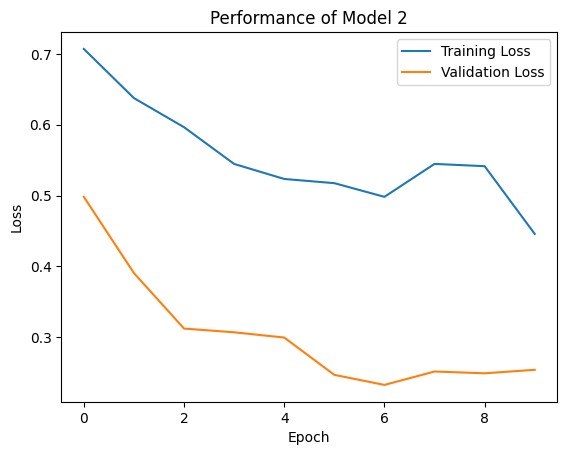

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses2, label="Training Loss")
plt.plot(range(num_epochs), val_losses2, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 2")
plt.legend()
plt.show()

In [ ]:
# Test the new model
test_model(model2, dataloaders["test"], criterion)

Test Loss: 0.2830
Test Accuracy: 0.9836


With the second model, we have an accuracy of 98% during testing, which is higher than the first model.

We could expect this because the second model is more complex.

**Apply the quantization (post and quantization aware) and evaluate impact on model size and accuracy.**

We load directly the quantized ResNet18 model from the pytorch models library, and we build again the classification layer on it.

In [ ]:
# Download a pre-trained ResNet18 model and freeze its weights
quantized_model = models.quantization.resnet18(
    weights=models.quantization.ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1,
    quantize=True
)

for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with two layers, ReLU activation, and dropout
num_ftrs = quantized_model.fc.in_features
quantized_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs//4),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs//4, 2),
    nn.Dropout(0.5),
)
# Send the model to the GPU
quantized_model = quantized_model.to(device)

In [ ]:
quantized_model = models.quantization.resnet18(
    weights=models.quantization.ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1,
    quantize=True
)
quantized_model_features = nn.Sequential(
    quantized_model.quant,  # Quantize the input
    quantized_model.conv1,
    quantized_model.bn1,
    quantized_model.relu,
    quantized_model.maxpool,
    quantized_model.layer1,
    quantized_model.layer2,
    quantized_model.layer3,
    quantized_model.layer4,
    quantized_model.avgpool,
    quantized_model.dequant,  # Dequantize the output
  )

# Step 2. Create a new "head"
new_head = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs//4),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs//4, 2),
    nn.Dropout(0.5),
)

# Step 3. Combine, and don't forget the quant stubs.
quantized_model = nn.Sequential(
  quantized_model_features,
  nn.Flatten(1),
  new_head,
)

In [ ]:
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(quantized_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
num_epochs = 10
quantized_model, epoch_time, train_losses_quant, val_losses_quant = train_model(
    quantized_model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs
)

Epoch 1/10
----------
train Loss: 0.5544 Acc: 0.6715
val Loss: 0.2284 Acc: 0.9831

Epoch 2/10
----------
train Loss: 0.3942 Acc: 0.8123
val Loss: 0.1759 Acc: 0.9831

Epoch 3/10
----------
train Loss: 0.3764 Acc: 0.7690
val Loss: 0.1144 Acc: 0.9831

Epoch 4/10
----------
train Loss: 0.2991 Acc: 0.8231
val Loss: 0.1195 Acc: 0.9831

Epoch 5/10
----------
train Loss: 0.2680 Acc: 0.8267
val Loss: 0.2102 Acc: 0.9492

Epoch 6/10
----------
train Loss: 0.3145 Acc: 0.7942
val Loss: 0.1040 Acc: 0.9661

Epoch 7/10
----------
train Loss: 0.3197 Acc: 0.8267
val Loss: 0.1587 Acc: 0.9153

Epoch 8/10
----------
train Loss: 0.2367 Acc: 0.8700
val Loss: 0.1330 Acc: 0.9492

Epoch 9/10
----------
train Loss: 0.2854 Acc: 0.8664
val Loss: 0.0849 Acc: 0.9661

Epoch 10/10
----------
train Loss: 0.2439 Acc: 0.8412
val Loss: 0.0787 Acc: 0.9831

Training complete in 4m 32s
Best val Acc: 0.983051


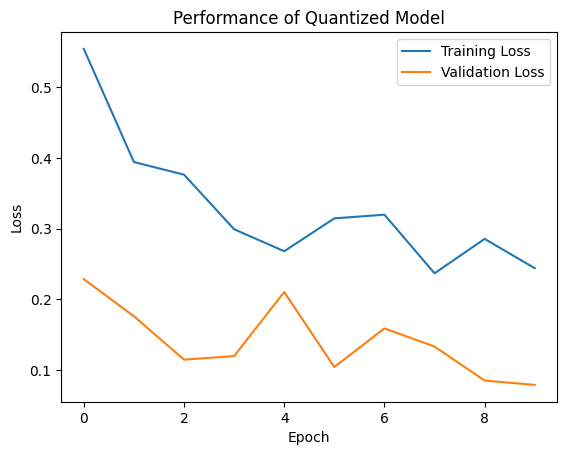

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses_quant, label="Training Loss")
plt.plot(range(num_epochs), val_losses_quant, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Quantized Model")
plt.legend()
plt.show()

In [ ]:
# Test the new model
test_model(quantized_model, dataloaders["test"], criterion)

Test Loss: 0.2489
Test Accuracy: 0.9180


In [ ]:
import os

def size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    os.remove("temp.p")
    return size

In [ ]:
original_size = size_of_model(model2)
quant_size = size_of_model(quantized_model)
print(f'Quantization size reduction: {round((original_size - quant_size)/original_size*100, 2)}%')

Quantization size reduction: 74.32%


We obtain an accuracy of 92% for the quantized model, wich is lower than the original model but still quite high (at the same level as the first model tested). The size of the model is reduced by 74%, so we can conclude that the quantization is effective on this model as it provides a strong size reduction while keeping relatively high accuracy.

Exercices made by Alberto BOSIO.